# 9장 잠재고객을 파악하기위한 이미지 인식 테크닉 10

In [ ]:
# 경고(warning) 무시
import warnings
warnings.filterwarnings('ignore')

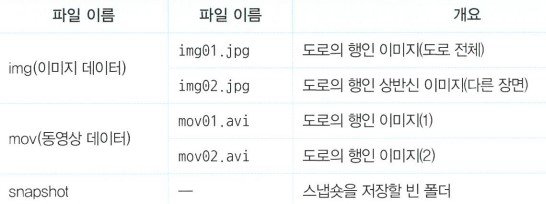

이미지 -> 인식 -> 정보

## 81. 이미지 데이터를 불러오자

<OpenCV 함수>
(이미지 데이터)
- imshow: 불러온 이미지 표시
- waitKey: 몇 초 동안 이미지를 표시할지 ms 단위로 지정

In [ ]:
import cv2
img = cv2.imread("img/img01.jpg")
height, width = img.shape[:2]
print("이미지 가로: " + str(width))
print("이미지 세로: " + str(height))
cv2.namedWindow("img",cv2.WINDOW_NORMAL)
cv2.imshow("img",img)
cv2.waitKey(0)
cv2.destroyAllWindows()

이미지 가로: 1920
이미지 세로: 1440


## 82. 동영상 데이터를 불러오자

<OpenCV 함수>
(동영상 데이터)
- VideoCapture: 동영상 불러오기
- cap: 불러온 동영상 정보 저장
- get: 정보 취득
- imshow: 표시

In [ ]:
import cv2

# 정보 취득
cap = cv2.VideoCapture("mov/mov01.avi")
width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
fps = cap.get(cv2.CAP_PROP_FPS)
print("가로: " + str(width))
print("세로: " + str(height))
print("총 프레임수: " + str(count))
print("FPS: " + str(fps))

# 출력
while(cap.isOpened()):
    ret, frame = cap.read()           # 저장된 정보를 프레임마다 처리하고 read
    if ret:
        cv2.imshow("frame", frame)
    if cv2.waitKey(1) & 0xFF == ord("q"): # 종료
        break
cap.release()
cv2.destroyAllWindows()

폭: 1920.0
높이: 1440.0
총 프레임수: 401.0
FPS: 30.0


## 83. 동영상을 이미지로 나누고 저장하자

동영상 데이터를 분할해서 이미지로 저장 -> snapshot 폴더

In [ ]:
import cv2
cap = cv2.VideoCapture("mov/mov01.avi")
num = 0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret:
        cv2.imshow("frame", frame)
        filepath = "snapshot/snapshot_" + str(num) + ".jpg"
        cv2.imwrite(filepath,frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    num = num + 1
cap.release()
cv2.destroyAllWindows()

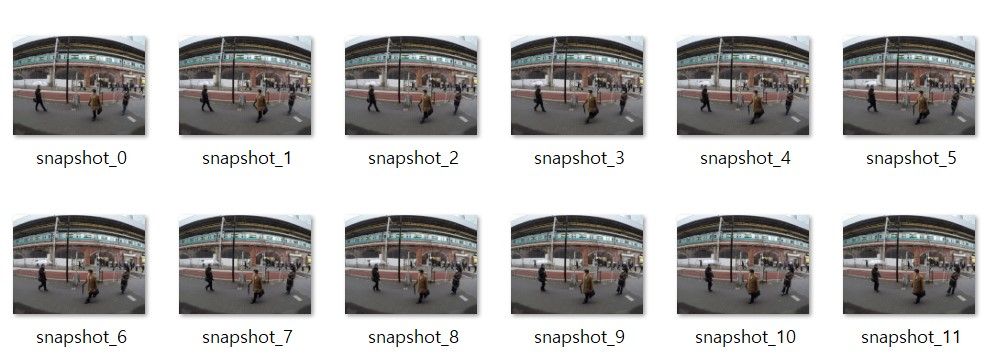

## 84. 이미지 속에 사람이 어디에 있는지 검출해보자

<'HOG' 특징량>     
- HOG: Histogram of Oriented Gradients (휘도의 기울기)
- 사람 실루엣 형태의 특징을 위치나 각도로 표현
- 선언: cv2.HOGDescriptor()
- 모델: .setSVMDetector()

In [ ]:
import cv2

# 준비
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
hogParams = {'winStride': (8, 8), 'padding': (32, 32), 'scale': 1.05, 'hitThreshold':0, 'finalThreshold':5}

# 검출
img = cv2.imread("img/img01.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)          # 흑백
human, r = hog.detectMultiScale(gray, **hogParams)    # 사람 검출
if (len(human)>0):
    for (x, y, w, h) in human:
        cv2.rectangle(img, (x, y), (x + w, y + h), (255,255,255), 3)  #rectangle 함수: 위치

cv2.namedWindow("img",cv2.WINDOW_NORMAL)
cv2.imshow("img",img)
cv2.imwrite("temp.jpg",img)
cv2.waitKey(0)
cv2.destroyAllWindows()

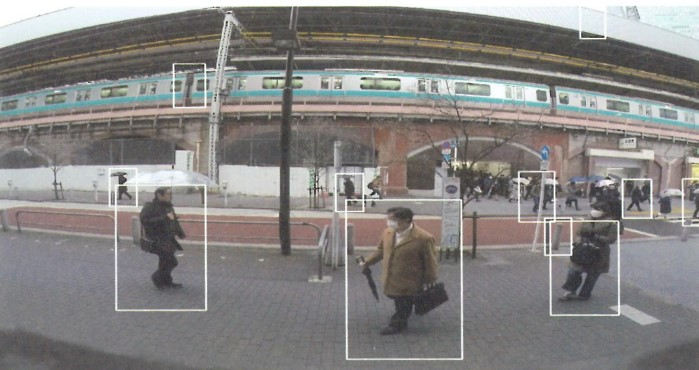

## 85. 이미지 속의 사람의 얼굴을 검출해보자

- 선언: cv2.CascadeClassifier( )
- 모델: "haarcascade_frontalface_alt.xml"

In [ ]:
import cv2

# 준비
cascade_file = "haarcascade_frontalface_alt.xml"
cascade = cv2.CascadeClassifier(cascade_file)

# 검출
img = cv2.imread("img/img02.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
face_list = cascade.detectMultiScale(gray, minSize=(50, 50))

# 검출한 얼굴 표시하기
for (x, y, w, h) in face_list:
    color = (0, 0, 225)
    pen_w = 3
    cv2.rectangle(img, (x, y), (x+w, y+h), color, thickness = pen_w)

cv2.namedWindow("img",cv2.WINDOW_NORMAL)
cv2.imshow("img",img)
cv2.imwrite("temp.jpg",img)
cv2.waitKey(0)
cv2.destroyAllWindows()

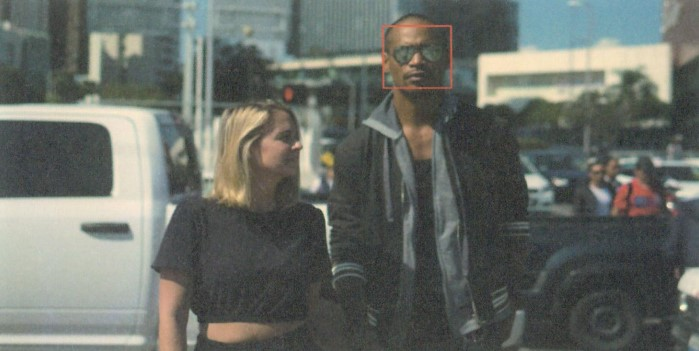

## 86. 이미지 속의 사람의 얼굴이 어느쪽을 보고 있는지 검출해보자

<dlib 라이브러리>
- 표정의 특징 파악
- 얼굴을 눈, 코, 입, 윤곽의 68개 특징점으로 표현
- shape_predictor: 68개의 얼굴 기관 모델 불러오기
- get_frontal_face_detector: 정면 얼굴 불러오기
> 윤곽 중심과 안쪽 중심의 차이로 얼굴의 방향 계산; deg(몇 도 틀어졌는지)

In [ ]:
import cv2
import dlib
import math

# 준비
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
detector = dlib.get_frontal_face_detector()

# 검출
img = cv2.imread("img/img02.jpg")
dets = detector(img, 1)

for k, d in enumerate(dets):
    shape = predictor(img, d)

    # 얼굴 영역 표시
    color_f = (0, 0, 225)
    color_l_out = (255, 0, 0)
    color_l_in = (0, 255, 0)
    line_w = 3
    circle_r = 3
    fontType = cv2.FONT_HERSHEY_SIMPLEX
    fontSize = 1
    cv2.rectangle(img, (d.left(), d.top()), (d.right(), d.bottom()), color_f, line_w)
    cv2.putText(img, str(k), (d.left(), d.top()), fontType, fontSize, color_f, line_w)

    # 중심을 계산할 사각형 준비
    num_of_points_out = 17
    num_of_points_in = shape.num_parts - num_of_points_out
    gx_out = 0
    gy_out = 0
    gx_in = 0
    gy_in = 0
    for shape_point_count in range(shape.num_parts):
        shape_point = shape.part(shape_point_count)
        #print("얼굴 랜드마크No.{} 좌표 위치: ({},{})".format(shape_point_count, shape_point.x, shape_point.y))
        #얼굴 랜드마크마다 그리기
        if shape_point_count<num_of_points_out:
            cv2.circle(img,(shape_point.x, shape_point.y),circle_r,color_l_out, line_w)
            gx_out = gx_out + shape_point.x/num_of_points_out
            gy_out = gy_out + shape_point.y/num_of_points_out
        else:
            cv2.circle(img,(shape_point.x, shape_point.y),circle_r,color_l_in, line_w)
            gx_in = gx_in + shape_point.x/num_of_points_in
            gy_in = gy_in + shape_point.y/num_of_points_in

    # 중심 위치 표시
    cv2.circle(img,(int(gx_out), int(gy_out)),circle_r,(0,0,255), line_w)
    cv2.circle(img,(int(gx_in), int(gy_in)),circle_r,(0,0,0), line_w)

    # 얼굴 방향 계산
    theta = math.asin(2*(gx_in-gx_out)/(d.right()-d.left()))
    radian = theta*180/math.pi
    print("얼굴 방향:{} (각도:{}도)".format(theta,radian))

    # 얼굴 방향 표시
    if radian<0:
        textPrefix = "   left "
    else:
        textPrefix = "   right "
    textShow = textPrefix + str(round(abs(radian),1)) + " deg."
    cv2.putText(img, textShow, (d.left(), d.top()), fontType, fontSize, color_f, line_w)


# cv2.imshow("img",img)
# cv2.imwrite("temp.jpg",img)
# cv2.waitKey(0)

cv2.namedWindow("img",cv2.WINDOW_NORMAL)
cv2.imshow("img",img)
cv2.imwrite("temp.jpg",img)
cv2.waitKey(0)
cv2.destroyAllWindows()

얼굴 방향:0.06253283992253719 (각도:3.582867808528563도)


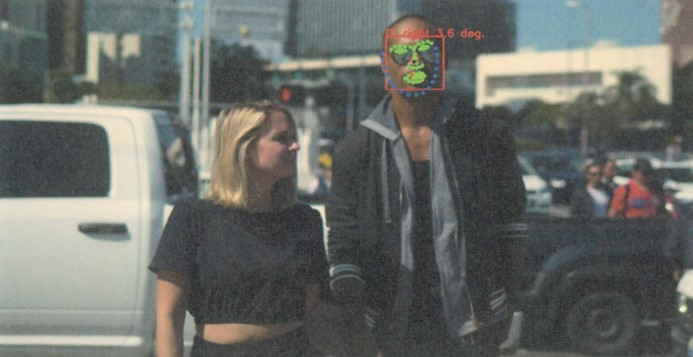

## 87. 검출한 정보를 종합해서, 타임랩스를 만들어보자

- 타임랩스: VideoWriter_fourcc 함수  
  - FourCC라는 네 개의 동영상 데이터 포맷을 지정함으로써 동영상 파일 작성
  - 'X', 'V', 'I', 'D' -> AVI형식으로 동영상 파일 작성  
  - write -> release


In [ ]:
import cv2

print("타임랩스 생성 시작")

# 동영상 읽어오기
cap = cv2.VideoCapture("mov/mov01.avi")
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# hog 선언
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
hogParams = {'winStride': (8, 8), 'padding': (32, 32), 'scale': 1.05, 'hitThreshold':0, 'finalThreshold':5}

# 타임랩스 작성
movie_name = "timelapse.avi"
fourcc = cv2.VideoWriter_fourcc('X', 'V', 'I', 'D')
video = cv2.VideoWriter(movie_name,fourcc, 30, (width,height))

num = 0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret:
        if (num%10==0):
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            human, r = hog.detectMultiScale(gray, **hogParams)
            if (len(human)>0):
                for (x, y, w, h) in human:
                    cv2.rectangle(frame, (x, y), (x + w, y + h), (255,255,255), 3)

            video.write(frame)
    else:
        break
    num = num + 1
video.release()
cap.release()
cv2.destroyAllWindows()
print("타임랩스 생성 완료")

타임랩스 생성 시작
타임랩스 생성 완료


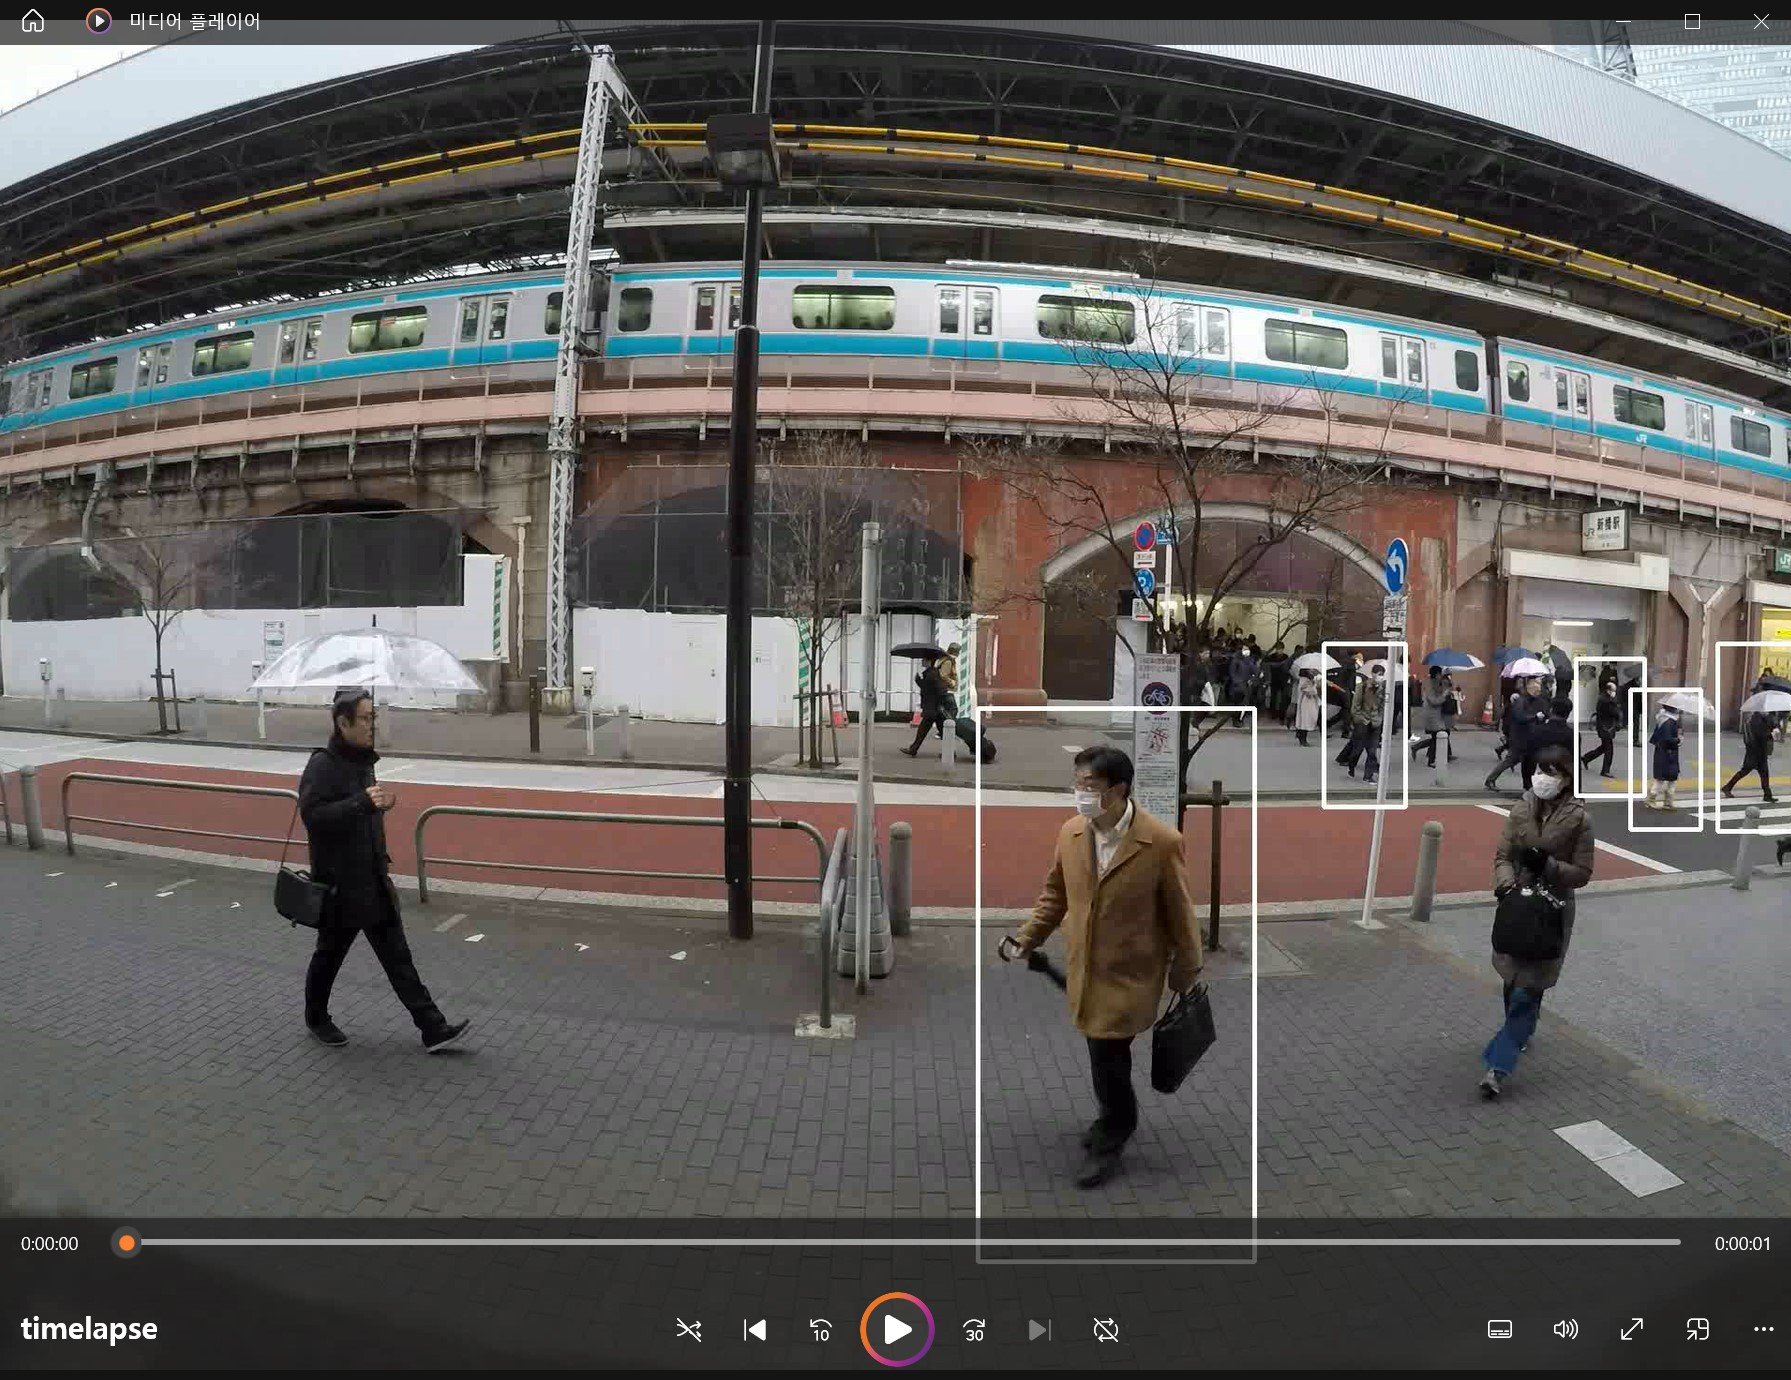

## 88. 전체모습을 그래프로 가시화해보자

동영상으로 사람을 검출한 후 시계열로 저장 -> 시계열 변화를 가시화; Matplotlib

In [ ]:
import cv2
import pandas as pd

print("분석 시작")
# 동영상 읽어오기
cap = cv2.VideoCapture("mov/mov01.avi")
fps = cap.get(cv2.CAP_PROP_FPS)

# hog 선언
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
hogParams = {'winStride': (8, 8), 'padding': (32, 32), 'scale': 1.05, 'hitThreshold':0, 'finalThreshold':5}

num = 0
list_df = pd.DataFrame( columns=['time','people'] )
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret:
        if (num%10==0):
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            human, r = hog.detectMultiScale(gray, **hogParams)
            if (len(human)>0):
                for (x, y, w, h) in human:
                    cv2.rectangle(frame, (x, y), (x + w, y + h), (255,255,255), 3)
            tmp_se = pd.Series( [num/fps,len(human) ], index=list_df.columns )
            list_df = list_df.append( tmp_se, ignore_index=True )
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    else:
        break
    num = num + 1
cap.release()
cv2.destroyAllWindows()
print("분석 종료")

분석 시작
분석 종료


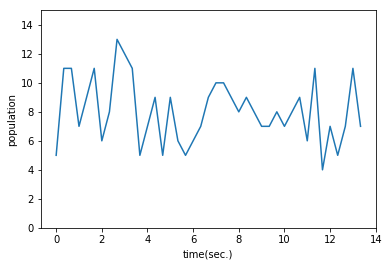

In [ ]:
import matplotlib.pyplot as plt
plt.plot(list_df["time"], list_df["people"])
plt.xlabel('time(sec.)')
plt.ylabel('population')
plt.ylim(0,15)
plt.show()

## 89. 거리의 변화를 그래프로 확인해보자

In [ ]:
import cv2
import pandas as pd

print("분석 시작")
# 동영상 읽어오기
cap = cv2.VideoCapture("mov/mov02.avi")
fps = cap.get(cv2.CAP_PROP_FPS)

# hog 선언
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
hogParams = {'winStride': (8, 8), 'padding': (32, 32), 'scale': 1.05, 'hitThreshold':0, 'finalThreshold':5}

num = 0
list_df2 = pd.DataFrame( columns=['time','people'] )
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret:
        if (num%10==0):
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            human, r = hog.detectMultiScale(gray, **hogParams)
            if (len(human)>0):
                for (x, y, w, h) in human:
                    cv2.rectangle(frame, (x, y), (x + w, y + h), (255,255,255), 3)
            tmp_se = pd.Series( [num/fps,len(human) ], index=list_df.columns )
            list_df2 = list_df2.append( tmp_se, ignore_index=True )
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    else:
        break
    num = num + 1
cap.release()
cv2.destroyAllWindows()
print("분석 종료")

분석 시작
분석 종료


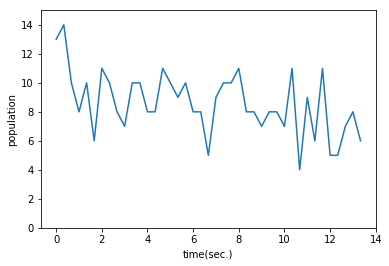

In [ ]:
import matplotlib.pyplot as plt
plt.plot(list_df2["time"], list_df2["people"])
plt.xlabel('time(sec.)')
plt.ylabel('population')
plt.ylim(0,15)
plt.show()

## 90. 이동평균을 계산해서 노이즈를 제거하자

- 오차 VS 노이즈  
   - 오차: 계산해야 할 사람을 계산하지 않아서 생긴다
   - 노이즈: 계산하지 않아도 될 사람을 계산해서 생긴다
- moving_average 함수  
   - 시간의 평균을 계산하면 사람의 숫자가 급증하거나 급감해서 생기는 오차를 줄일 수 있다.

In [ ]:
import numpy as np
def moving_average(x, y):
    y_conv = np.convolve(y, np.ones(5)/float(5), mode='valid')
    x_dat = np.linspace(np.min(x), np.max(x), np.size(y_conv))
    return x_dat, y_conv

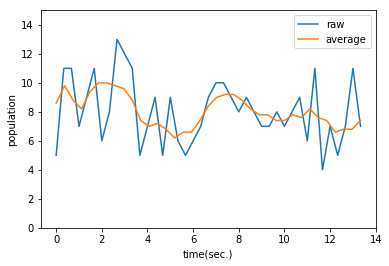

In [ ]:
plt.plot(list_df["time"], list_df["people"], label="raw")
ma_x, ma_y = moving_average(list_df["time"], list_df["people"])
plt.plot(ma_x,ma_y, label="average")
plt.xlabel('time(sec.)')
plt.ylabel('population')
plt.ylim(0,15)
plt.legend()
plt.show()

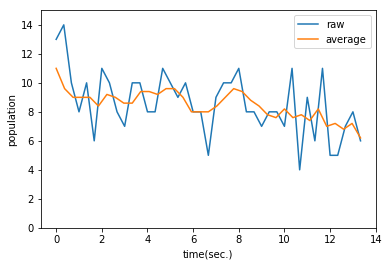

In [ ]:
plt.plot(list_df2["time"], list_df2["people"], label="raw")
ma_x2, ma_y2 = moving_average(list_df2["time"], list_df2["people"])
plt.plot(ma_x2,ma_y2, label="average")
plt.xlabel('time(sec.)')
plt.ylabel('population')
plt.ylim(0,15)
plt.legend()
plt.show()

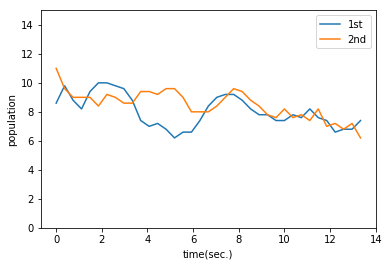

In [ ]:
plt.plot(ma_x,ma_y, label="1st")
plt.plot(ma_x2,ma_y2, label="2nd")
plt.xlabel('time(sec.)')
plt.ylabel('population')
plt.ylim(0,15)
plt.legend()
plt.show()